# Описание проекта

В нашем распоряжении имеются три датасета с тремя интернет-магазинам: мультикатегорийный магазин с посещаемостью более 8 млн сессий в месяц, магазин одежды, маленький магазин подарков. В них есть обезличенная история покупок клиентов за определенный период. Наша цель состоит в том, чтобы создать решение для предсказания, совершит ли покупатель повторную покупку в течение ближайших 30 дней.

Для реализации проекта составим план действий.

<font size="4"><b>План:</b></font>
1. Знакомство с датасетами.
2. Создание фиксированных признаков.
3. Создание последовательных признаков
4. Создание и обучение модели.
5. Тестирование модели.
6. Вывод и рекомендации по проделанной работе.

<font size="4"><b>Цель проекта:</b></font>

В данном проекте я буду реализовывать предсказание повторной покупки клиента через признаки клиентов и последовальные признаки. Для признаков клиентов я выбрал следующие признаки:
- дата последнего заказа ('last_order');
- минимальное количество дней между двумя последовательными заказами ('min_cons_dur');
- среднее количество дней между всеми заказами клиента ('avg_cons_dur');
- максимальное количество дней между двумя последовательными заказами ('max_cons_dur');
- среднеквадратичное отклонение в днях между двумя последовательными заказами в единицу продукта ('avg_fluc'):
- количество дней, прошедшее с первой покупки ('days_from_first');
- количество дней, прошедшее с последней покупки ('days_from_last');
- количество товаров в последнем заказе ('last_prod_am');
- общее количество купленных товаров ('quantity_sum');
- общее количество потраченных денег ('sum_order_value');
- среднее количество денег, потраченных на один товар ('mean_order_value');
- кластер покупателя, в зависимости от RFM анализа клиентов ('cluster').

Для последовательных признаков выбрал следующие последовательности:
- последовательности из суммарно потраченных денег за заказ ('total');
- последовательность из разницы количества дней между заказами ('diff_days');
- последовательность из разницы между датой покупки и последней даты для фиксации признаков ('last_order').

Для обучения и предсказания воспользуемся рекуррентной нейронной сетью LSTM, позволяющей работать с признаками в виде последовательностей. 

## Знакомство датасетами

Импортируем все необходимые библиотеки.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

from keras.models import Model
from keras.layers import LSTM, Dense, Masking, Input, Concatenate
from keras.utils import pad_sequences, plot_model, set_random_seed

In [3]:
MASK_VALUE = -1
plt.style.use('ggplot')
set_random_seed(7)
np.random.seed(7)

Прочитаем датасеты.

In [4]:
apparel = pd.read_csv('apparel-purchases.csv')
gifts = pd.read_csv('gifts-purchases.csv')
marketplace = pd.read_csv('marketplace-purchases.csv')

Просмотрим первые 5 строк и общую информацию датасета 'apparel'.

In [5]:
display(apparel.head())
apparel.info()

,client_id,quantity,price,date,message_id,recommended_by
0,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
1,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
2,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
3,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
4,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133104 entries, 0 to 133103
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   client_id       133104 non-null  int64  
 1   quantity        133104 non-null  int64  
 2   price           133104 non-null  float64
 3   date            133104 non-null  object 
 4   message_id      133104 non-null  object 
 5   recommended_by  133104 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 6.1+ MB


Просмотрим первые 5 строк и общую информацию датасета 'gifts'.

In [6]:
display(gifts.head())
gifts.info()

,client_id,quantity,price,date,message_id,recommended_by
0,1515915625803894158,1,8943.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
1,1515915625803894158,1,46369.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
2,1515915625803894158,1,4666.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
3,1515915625803894158,1,11963.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
4,1515915625803894158,1,13107.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811 entries, 0 to 810
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       811 non-null    int64  
 1   quantity        811 non-null    int64  
 2   price           811 non-null    float64
 3   date            811 non-null    object 
 4   message_id      811 non-null    object 
 5   recommended_by  811 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 38.1+ KB


Просмотрим первые 5 строк и общую информацию датасета 'marketplace'.

In [7]:
display(marketplace.head())
marketplace.info()

,client_id,quantity,price,message_id,created_at,date
0,1515915625440944408,1,6298.0,1515915625440944408-1752-6450b79616277,2023-05-02,2023-05-02 08:49:57
1,1515915625440992498,1,7318.0,1515915625440992498-1818-646b35d089c98,2023-05-22,2023-05-22 13:52:13
2,1515915625441026424,1,65798.0,1515915625441026424-1802-64634e24a2cb9,2023-05-17,2023-05-17 11:21:04
3,1515915625441118180,1,5598.0,1515915625441118180-1820-646c9444ebf39,2023-05-23,2023-05-23 19:02:53
4,1515915625441124500,1,77998.0,1515915625441124500-1825-646ed5cf4d5ed,2023-05-25,2023-05-25 07:46:52


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48182 entries, 0 to 48181
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   client_id   48182 non-null  int64  
 1   quantity    48182 non-null  int64  
 2   price       48182 non-null  float64
 3   message_id  48182 non-null  object 
 4   created_at  48182 non-null  object 
 5   date        48182 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 2.2+ MB


Удалим ненужные признаки из датасетов, а также переименуем признак 'created_at' в признак 'date' в датасете 'marketplace'.

In [8]:
apparel.drop(['recommended_by'], axis= 1 , inplace= True)

gifts.drop(['recommended_by'], axis= 1 , inplace= True)

marketplace.drop(['date'], axis= 1 , inplace= True)

marketplace = marketplace.rename(columns={"created_at": "date"})

Проверим отсутствие общих значений признака 'client_id' в трех датасетах.

In [9]:
print(
    "Количество общих значение признака 'clien_id' между датасетами 'apparel' и 'gifts':",
    len(apparel.loc[apparel["client_id"].isin(gifts["client_id"]), "client_id"]),
)

print(
    "Количество общих значение признака 'clien_id' между датасетами 'gifts' и 'marketplace':",
    len(gifts.loc[gifts["client_id"].isin(marketplace["client_id"]), "client_id"]),
)

print(
    "Количество общих значение признака 'clien_id' между датасетами 'marketplace' и 'apparel':",
    len(
        marketplace.loc[
            marketplace["client_id"].isin(apparel["client_id"]), "client_id"
        ]
    ),
)


Количество общих значение признака 'clien_id' между датасетами 'apparel' и 'gifts': 0
Количество общих значение признака 'clien_id' между датасетами 'gifts' и 'marketplace': 0
Количество общих значение признака 'clien_id' между датасетами 'marketplace' и 'apparel': 0


Как можно заметить, общие значениея признака 'client_id' отсутствуют.

Объединим наши датасеты в один.

In [10]:
df = pd.concat([apparel, gifts, marketplace])

Рассмотрим первые 5 строк датасета и общую информацию о нем.

In [11]:
display(df.head())
df.info()

,client_id,quantity,price,date,message_id
0,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56
1,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56
2,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56
3,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56
4,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56


<class 'pandas.core.frame.DataFrame'>
Int64Index: 182097 entries, 0 to 48181
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   client_id   182097 non-null  int64  
 1   quantity    182097 non-null  int64  
 2   price       182097 non-null  float64
 3   date        182097 non-null  object 
 4   message_id  182097 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 8.3+ MB


Изменим тип данных в признаке 'date'.

In [12]:
df['date'] = pd.to_datetime(df['date'])

Определим минимальную дату во всех заказах.

In [13]:
date_start = df['date'].min()
date_start

Timestamp('2022-10-26 00:00:00')

Определим максимальную дату во всех заказах.

In [14]:
date_end = df['date'].max()
date_end

Timestamp('2023-10-26 00:00:00')

Так как нам нужно определить покупателя, который сделает заказ в следующих 30 дней, то создадим предельную дату, до которой можно делать заказы и на основе которых будем тренировать будущие модели.

In [15]:
date_limit = df['date'].max() - timedelta(days=30)
date_limit

Timestamp('2023-09-26 00:00:00')

Разделим наш датасет на датасеты для формирования признаков и на датасет, в котором будет определяться таргет.

In [16]:
df_features = df[df['date'] < date_limit]
display(df_features.head())
df_features.info()

,client_id,quantity,price,date,message_id
0,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56
1,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56
2,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56
3,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56
4,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56


<class 'pandas.core.frame.DataFrame'>
Int64Index: 173595 entries, 0 to 48181
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   client_id   173595 non-null  int64         
 1   quantity    173595 non-null  int64         
 2   price       173595 non-null  float64       
 3   date        173595 non-null  datetime64[ns]
 4   message_id  173595 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 7.9+ MB


Создадим датасет, который будем использовать для создания таргетов.

In [17]:
df_target = df.loc[df['date']>=date_limit, 'client_id'].unique()

Отсортируем датасет для обучения моделей по возрастанию 'client_id' и 'date'.

In [18]:
df_features = df_features.sort_values(['client_id', 'date'], ascending=True)

Создадим датасет с разницей дней между покупками.

In [19]:
df_features['diff_days'] = df_features.groupby('client_id')['date'].transform('diff').dt.days.fillna(0).astype(int)
display(df_features.head())

,client_id,quantity,price,date,message_id,diff_days
2644,1515915625440099873,1,31998.0,2023-07-16,1515915625440099873-1965-64abd07b9561d,0
25171,1515915625440099873,1,1218.0,2023-08-09,1515915625440099873-2021-64d219c458813,24
2396,1515915625440939402,1,75998.0,2023-01-30,1515915625440939402-1474-63d738fa8d5cc,0
434,1515915625440944408,1,882.0,2023-03-01,1515915625440944408-1587-63fef11f97d27,0
0,1515915625440944408,1,6298.0,2023-05-02,1515915625440944408-1752-6450b79616277,62


In [20]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173595 entries, 2644 to 205
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   client_id   173595 non-null  int64         
 1   quantity    173595 non-null  int64         
 2   price       173595 non-null  float64       
 3   date        173595 non-null  datetime64[ns]
 4   message_id  173595 non-null  object        
 5   diff_days   173595 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(2), object(1)
memory usage: 8.6+ MB


## Создание фиксированных признаков

Создадим новый датасет с агрегируемыми признаками.

In [21]:
features_fix = pd.DataFrame()

Создадим признак с значением минимального количества дней между соседними заказами у каждого клиента.

In [22]:
features_fix["min_cons_dur"] = df_features.groupby(by='client_id')['diff_days'].agg('min')

Создадим признак с значением среднего количества дней между соседними заказами у каждого клиента.

In [23]:
features_fix["avg_cons_dur"] = df_features.groupby(by='client_id')['diff_days'].agg('mean').round(1)

Создадим признак с значением максимального количествва дней между соседними заказами у каждого клиента.

In [24]:
features_fix['max_cons_dur'] = df_features.groupby('client_id')['diff_days'].agg('max')

Создадим признак со значением среднеквадратичного отклонения в днях между последовательными заказами.

In [25]:
features_fix['avg_fluc']  = df_features.groupby('client_id').apply(lambda x: x.date.diff().std()).dt.days.fillna(0).astype(int)

Создадим признакми со значением количеcтва дней между первой и предельной даты покупки,  а также датой последней покупкой и предельной даты покупки.

In [26]:
df_features['last_order'] = (date_limit - df_features['date']).dt.days.fillna(0).astype(int)
display(df_features.head())
features_fix['days_from_last'] = df_features.groupby('client_id')['last_order'].agg('last')
features_fix['days_from_first'] = df_features.groupby('client_id')['last_order'].agg('first')
display(features_fix.head())

,client_id,quantity,price,date,message_id,diff_days,last_order
2644,1515915625440099873,1,31998.0,2023-07-16,1515915625440099873-1965-64abd07b9561d,0,72
25171,1515915625440099873,1,1218.0,2023-08-09,1515915625440099873-2021-64d219c458813,24,48
2396,1515915625440939402,1,75998.0,2023-01-30,1515915625440939402-1474-63d738fa8d5cc,0,239
434,1515915625440944408,1,882.0,2023-03-01,1515915625440944408-1587-63fef11f97d27,0,209
0,1515915625440944408,1,6298.0,2023-05-02,1515915625440944408-1752-6450b79616277,62,147


,min_cons_dur,avg_cons_dur,max_cons_dur,avg_fluc,days_from_last,days_from_first
client_id,,,,,,
1515915625440099873,0,12.0,24,0,48,72
1515915625440939402,0,0.0,0,0,239,239
1515915625440944408,0,37.3,62,8,97,209
1515915625440947454,0,12.0,48,27,276,324
1515915625440952940,0,0.0,0,0,319,319


Создадим признак со значением количества товара, приобретенное в последней покупке.

In [27]:
features_fix['last_prod_am'] = df_features.groupby(['client_id'])['quantity'].agg('last')

In [28]:
display(features_fix.head())

,min_cons_dur,avg_cons_dur,max_cons_dur,avg_fluc,days_from_last,days_from_first,last_prod_am
client_id,,,,,,,
1515915625440099873,0,12.0,24,0,48,72,1
1515915625440939402,0,0.0,0,0,239,239,1
1515915625440944408,0,37.3,62,8,97,209,1
1515915625440947454,0,12.0,48,27,276,324,1
1515915625440952940,0,0.0,0,0,319,319,1


Создадим признак со значением суммарного количества покупок для каждого клиента.

In [29]:
features_fix['quantity_sum'] = df_features.groupby(['client_id'])['quantity'].agg('sum')

Создадим с суммарной суммой, потраченной каждым клиентом.

In [30]:
features_fix['sum_order_value'] = df_features.groupby(['client_id'])['price'].agg('sum')

Рассмотрим обновленный датасет 'df_agg'.

In [31]:
display(features_fix.head())

,min_cons_dur,avg_cons_dur,max_cons_dur,avg_fluc,days_from_last,days_from_first,last_prod_am,quantity_sum,sum_order_value
client_id,,,,,,,,,
1515915625440099873,0,12.0,24,0,48,72,1,2,33216.0
1515915625440939402,0,0.0,0,0,239,239,1,1,75998.0
1515915625440944408,0,37.3,62,8,97,209,1,3,81178.0
1515915625440947454,0,12.0,48,27,276,324,1,4,4486.0
1515915625440952940,0,0.0,0,0,319,319,1,1,479.0


Создадим признак со значением средней суммы, потраченной на один товар, на каждого клиента.

In [32]:
features_fix['mean_order_value'] = (features_fix['sum_order_value'] / features_fix['quantity_sum']).round(1)

Рассмотрим обновленный датасет.

In [33]:
display(features_fix.head())

,min_cons_dur,avg_cons_dur,max_cons_dur,avg_fluc,days_from_last,days_from_first,last_prod_am,quantity_sum,sum_order_value,mean_order_value
client_id,,,,,,,,,,
1515915625440099873,0,12.0,24,0,48,72,1,2,33216.0,16608.0
1515915625440939402,0,0.0,0,0,239,239,1,1,75998.0,75998.0
1515915625440944408,0,37.3,62,8,97,209,1,3,81178.0,27059.3
1515915625440947454,0,12.0,48,27,276,324,1,4,4486.0,1121.5
1515915625440952940,0,0.0,0,0,319,319,1,1,479.0,479.0


Создадим признак 'total' со значением проивзедения количества товра на его стоимость.

In [34]:
df_features['total'] = df_features['quantity'] * df_features['price']

Для кластеризации покупателя проведем RFM анализ и создадим категориальный признак 'cluster'.

В RFM анализе:

Давность (R): Как недавно конкретный клиент совершил покупку?

Частота (F): Как часто клиент совершает покупки?

Потраченные деньги (M): Сколько денег клиент тратят?

In [35]:
rfm = df_features.groupby("client_id").agg(
    {
        "date": lambda x: (date_limit - x.max()).days,
        "message_id": "nunique",
        "total": "sum",
    }
)
rfm.rename(
    columns={"date": "recency", "message_id": "frequency", "total": "monetary_value"},
    inplace=True,
)
display(rfm.head())


,recency,frequency,monetary_value
client_id,,,
1515915625440099873,48,2,33216.0
1515915625440939402,239,1,75998.0
1515915625440944408,97,3,81178.0
1515915625440947454,276,2,4486.0
1515915625440952940,319,1,479.0


Рассмотрим общую статистическую информацию о датасете 'rfm'.

In [36]:
rfm.describe()

,recency,frequency,monetary_value
count,44619.000000,44619.000000,4.461900e+04
mean,166.920706,1.173357,3.108600e+04
std,94.915114,0.732409,1.480062e+05
min,1.000000,1.000000,0.000000e+00
25%,95.000000,1.000000,1.999000e+03
50%,157.000000,1.000000,4.898000e+03
75%,256.000000,1.000000,1.799800e+04
max,335.000000,35.000000,1.730038e+07


Теперь  сопоставим столбцы «recency», «frequency» и «monetary_value», чтобы они принимали значения в шкале от 1 до 5.
По сути, мы назначим значения пяти различным ячейкам и сопоставим каждую ячейку со значением. Чтобы исправить границы интервала,  воспользуемся значениями квантилей столбцов «recency», «frequency» и «monetary_value»:

In [37]:
# вычислим пользовательские границы интервала для оценок "давности", "частоты" и "потраченных денег".
recency_bins = [rfm['recency'].min()- 0, 90, 150, 250, 300, rfm['recency'].max()]
frequency_bins = [rfm['frequency'].min() - 1, 0.9, 1.0, 1.1, 1.2, rfm['frequency'].max()]
monetary_bins = [rfm['monetary_value'].min() - 0, 2000, 4900, 18000, 50000, rfm['monetary_value'].max()]

Обратим внимание, что r_score, основанный на бинах, равен 1 для недавних покупок и 5 для покупок, совершенных более 300 дней назад. Изменим значение r_score так, чтобы самые последние покупки имели r_score, равный 5, а покупки, совершенные более 300 дней назад, имели r_score, равный 1.

In [38]:
# рассчитаем показатель "давности" на основе пользовательских подборок
rfm['r_score'] = pd.cut(rfm['recency'], bins=recency_bins, labels=range(1, 6), include_lowest=True)

# поменяем местами показатели "давности", чтобы более высокие значения указывали на более недавние покупки.
rfm['r_score'] = 5 - rfm['r_score'].astype(int) + 1

# рассчитаем "частоту" и "потраченные деньги" на основе пользовательских подборок
rfm['f_score'] = pd.cut(rfm['frequency'], bins=frequency_bins, labels=range(1, 6), include_lowest=True).astype(int)
rfm['m_score'] = pd.cut(rfm['monetary_value'], bins=monetary_bins, labels=range(1, 6), include_lowest=True).astype(int)

In [39]:
# отобразим первые несколько строк rfm датасета, чтобы проверить оценки
print(rfm[['r_score', 'f_score', 'm_score']].head())

                     r_score  f_score  m_score
client_id                                     
1515915625440099873        5        5        4
1515915625440939402        3        2        5
1515915625440944408        4        5        5
1515915625440947454        2        5        2
1515915625440952940        1        2        1


Кластеризация K-Means чувствительна к масштабу объектов. Поскольку все значения R, F и M находятся в одном масштабе, мы можем приступить к кластеризации без дальнейшего масштабирования объектов.

Извлечем оценки R, F и M, чтобы выполнить кластеризацию K-средних:

In [40]:
# извлекем оценки rfm для кластеризации K-средних
X = rfm[['r_score', 'f_score', 'm_score']]

Найдем оптимальное количество кластеров. Для этого запустим алгоритм K-Means для диапазона значений K и воспользуемся Elbow Curve, чтобы выбрать оптимальное значение K:

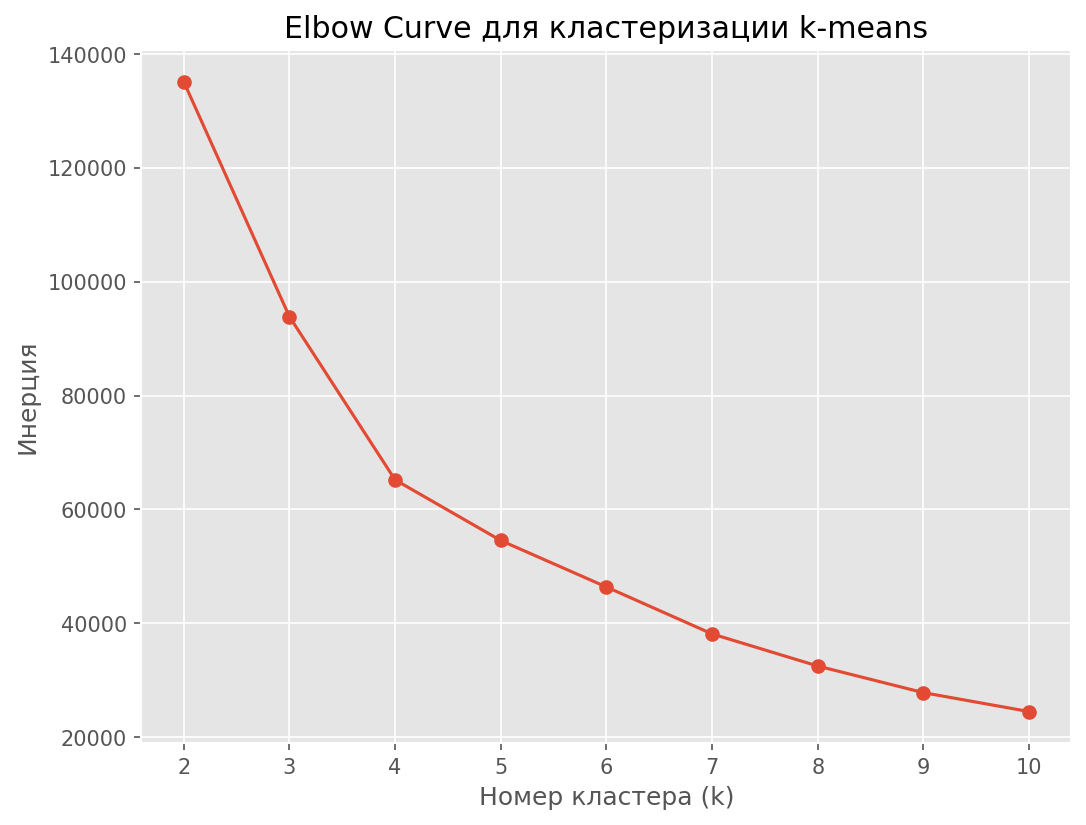

In [41]:
# рассчитаем инерцию (сумму квадратов расстояний) для разных значений k.
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init= 10, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# график Elbow Curve
plt.figure(figsize=(8, 6),dpi=150)
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Номер кластера (k)')
plt.ylabel('Инерция')
plt.title('Elbow Curve для кластеризации k-means')
plt.grid(True)
plt.show()

Как можно заметить кривая изгибается в 4 кластерах. Итак, давайте разделим клиентскую базу на четыре сегмента.

In [42]:
# Выполним K-means кластеризация с k=4
best_kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
rfm['cluster'] = best_kmeans.fit_predict(X)

Теперь, когда у нас есть кластеры, давайте попробуем охарактеризовать их на основе оценок RFM.

In [43]:
# сгруппируем по кластерам и рассчитывать средние значения
cluster_summary = rfm.groupby('cluster').agg({
    'r_score': 'mean',
    'f_score': 'mean',
    'm_score': 'mean'
}).reset_index()

Средние баллы R, F и M для каждого кластера уже должны дать  представление о характеристиках.

In [44]:
display(cluster_summary)

,cluster,r_score,f_score,m_score
0,0,3.819506,2.00000,3.827831
1,1,1.476378,2.01268,2.276604
2,2,3.883730,5.00000,3.599878
3,3,3.974020,2.00000,1.481126


Визуализируем средние значения R, F и M для кластеров, чтобы их было легко интерпретировать.

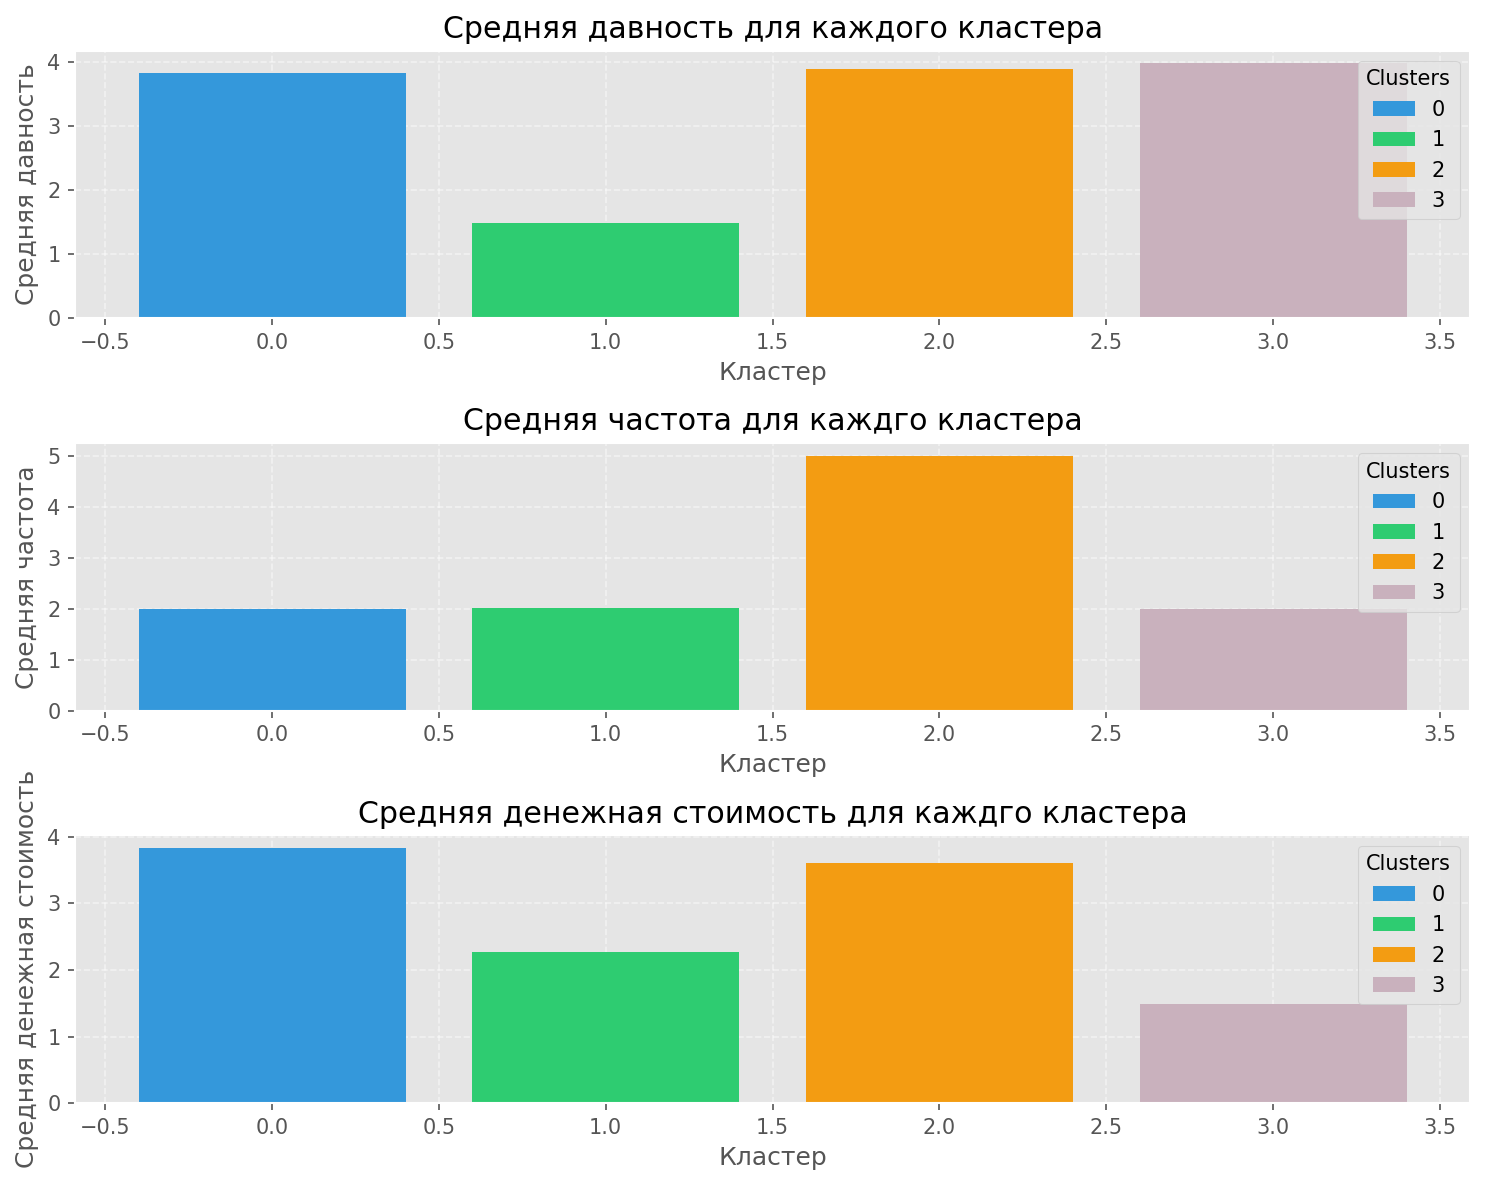

In [45]:
colors = ["#3498db", "#2ecc71", "#f39c12", "#C9B1BD"]

# Постройте средние значения RFM для каждого кластера
plt.figure(figsize=(10, 8), dpi=150)

# Пострим график средней "давности"
plt.subplot(3, 1, 1)
bars = plt.bar(cluster_summary.index, cluster_summary["r_score"], color=colors)
plt.xlabel("Кластер")
plt.ylabel("Средняя давность")
plt.title("Средняя давность для каждого кластера")

plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(bars, cluster_summary.index, title="Clusters")

# Построим график средней "частоты"
plt.subplot(3, 1, 2)
bars = plt.bar(cluster_summary.index, cluster_summary["f_score"], color=colors)
plt.xlabel("Кластер")
plt.ylabel("Средняя частота")
plt.title("Средняя частота для каждго кластера")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(bars, cluster_summary.index, title="Clusters")

# построим график средней "потраченных денег"
plt.subplot(3, 1, 3)
bars = plt.bar(cluster_summary.index, cluster_summary["m_score"], color=colors)
plt.xlabel("Кластер")
plt.ylabel("Средняя денежная стоимость")
plt.title("Средняя денежная стоимость для каждго кластера")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(bars, cluster_summary.index, title="Clusters")

plt.tight_layout()
plt.show()


Как можно заметить из всех кластеров выделяется кластер номер 2. Данный кластер имеет стабильную высокую давность, частоту и потраченные деньги. Назовем этот кластер "влиятельные покупатели".

Кластер с номером 0 С наивысшей давностью и денежной стоимостью имеют низкую частоту, скорее всего данный кластер описывает "лояльного" клиента. 

Кластер с номером 1 описывает недавних клиентов, так как данный кластер имеет низкую давность, низкую частоту и умеренную денежную стоимость. 

Кластер с номером 3 описывает клиентов из группа риска, так как это давние клиенты, имеющие низкую денежную стоимость, среднюю частоту и высокую давность.

Добавим в наш датасет с постоянными признаками признак "cluster".

In [46]:
features_fix = features_fix.merge(rfm, left_on='client_id', right_on='client_id', how='inner')
features_fix.drop(['recency', 'frequency', 'monetary_value', 'r_score', 'f_score', 'm_score'], axis= 1 , inplace= True)

Рассмотрим новый датасет.

In [47]:
display(features_fix.head())

,min_cons_dur,avg_cons_dur,max_cons_dur,avg_fluc,days_from_last,days_from_first,last_prod_am,quantity_sum,sum_order_value,mean_order_value,cluster
client_id,,,,,,,,,,,
1515915625440099873,0,12.0,24,0,48,72,1,2,33216.0,16608.0,2
1515915625440939402,0,0.0,0,0,239,239,1,1,75998.0,75998.0,0
1515915625440944408,0,37.3,62,8,97,209,1,3,81178.0,27059.3,2
1515915625440947454,0,12.0,48,27,276,324,1,4,4486.0,1121.5,2
1515915625440952940,0,0.0,0,0,319,319,1,1,479.0,479.0,1


In [48]:
# features_fix.columns = ['_'.join(col) for col in features_fix]
features_fix = features_fix.reset_index()
display(features_fix.head())

,client_id,min_cons_dur,avg_cons_dur,max_cons_dur,avg_fluc,days_from_last,days_from_first,last_prod_am,quantity_sum,sum_order_value,mean_order_value,cluster
0,1515915625440099873,0,12.0,24,0,48,72,1,2,33216.0,16608.0,2
1,1515915625440939402,0,0.0,0,0,239,239,1,1,75998.0,75998.0,0
2,1515915625440944408,0,37.3,62,8,97,209,1,3,81178.0,27059.3,2
3,1515915625440947454,0,12.0,48,27,276,324,1,4,4486.0,1121.5,2
4,1515915625440952940,0,0.0,0,0,319,319,1,1,479.0,479.0,1


## Создание последовательных признаков

Используем Scaler для масштабирования признаков для последовательных признаков.

In [49]:
scaler = MinMaxScaler(feature_range=(0, 1))

Применим масштабирования к признакам до агрегации.

In [50]:
fetures_to_scale = ['total', 'diff_days', 'last_order']
scaled_names = [f'{col}_scaled' for col in fetures_to_scale]
df_features[scaled_names] = scaler.fit_transform(df_features[fetures_to_scale]).round(3)
display(df_features[scaled_names].head()) 

,total_scaled,diff_days_scaled,last_order_scaled
2644,0.023,0.000,0.213
25171,0.001,0.074,0.141
2396,0.054,0.000,0.713
434,0.001,0.000,0.623
0,0.004,0.191,0.437


Агрегируем признаки в последовательный признак.

In [51]:
features_seq = df_features.groupby('client_id')[scaled_names].agg(list).reset_index()
display(features_seq.head())

,client_id,total_scaled,diff_days_scaled,last_order_scaled
0,1515915625440099873,"[0.023, 0.001]","[0.0, 0.074]","[0.213, 0.141]"
1,1515915625440939402,[0.054],[0.0],[0.713]
2,1515915625440944408,"[0.001, 0.004, 0.053]","[0.0, 0.191, 0.154]","[0.623, 0.437, 0.287]"
3,1515915625440947454,"[0.0, 0.0, 0.0, 0.003]","[0.0, 0.0, 0.148, 0.0]","[0.967, 0.967, 0.823, 0.823]"
4,1515915625440952940,[0.0],[0.0],[0.952]


## Создание и обучение модели.

Преобразуем последовательные признаки в двухмерную матрицу. 

In [52]:
pad_sequence = lambda x: pad_sequences(
    x.values, dtype=float, value=MASK_VALUE, padding="post"
)
reshape = lambda x: x.reshape(x.shape+(1,))
to_drop_names = ['client_id']
X_seq = np.concatenate(
    [
        reshape(pad_sequence(features_seq[col]))
        for col in features_seq.drop(to_drop_names, axis=1)
    ],
    axis=2,
)

X_seq.shape

(44619, 280, 3)

Масштабируем признаки покупателей в диапазон от 0 до 1.

In [53]:
scaler_fix = MinMaxScaler(feature_range=(0,1))
X_fix = scaler_fix.fit_transform(features_fix.drop('client_id', axis=1))
X_fix.shape

(44619, 11)

Создадим выборку с таргетом.

In [54]:
y = features_seq['client_id'].isin(df_target).astype(int)
print(y)
display(y.value_counts(normalize=True).to_frame().style.format('{:.2%}'.format).bar())
y = y.values
y.shape

0        0
1        0
2        0
3        0
4        0
        ..
44614    0
44615    0
44616    0
44617    0
44618    0
Name: client_id, Length: 44619, dtype: int32


,client_id
0,98.50%
1,1.50%


(44619,)

Разделим выборки на тренировочный и тестовые наборы.

In [55]:
X_train_seq, X_test_seq, X_train_fix, X_test_fix, y_train, y_test = train_test_split(
    X_seq, X_fix, y, test_size=0.25, random_state=7
)

Создадим входные наборы для модели LSTM.

In [56]:
input_seq = Input(shape=X_train_seq.shape[1:])
input_fix = Input(shape=X_train_fix.shape[1:])

print(input_seq.shape, input_fix.shape)

(None, 280, 3) (None, 11)


Создадим модель LSTM.

In [57]:
module_seq = Masking(mask_value=MASK_VALUE)(input_seq)
module_seq = LSTM(16)(module_seq)

module_fix = Dense(16, activation='relu')(input_fix)

merged = Concatenate()([module_seq, module_fix])
output = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[input_seq, input_fix], outputs=output)
model.compile(loss='binary_crossentropy', metrics=['auc'])

Визуализируем модель.

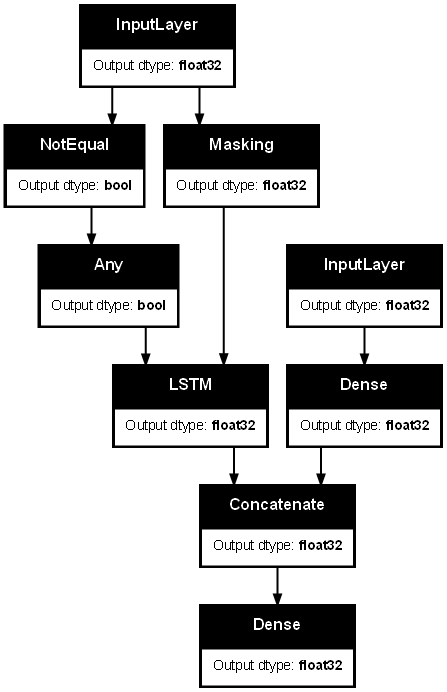

In [58]:
plot_model(model, dpi=72, show_layer_activations=False, show_shapes=False, show_dtype=True)
# printmodel.summary())

Обучим модель LSTM.

In [59]:
model.fit([X_train_seq, X_train_fix], y_train, validation_split=0.2, epochs=6, batch_size=32)

Epoch 1/6
837/837 ━━━━━━━━━━━━━━━━━━━━ 94s 109ms/step - auc: 0.5537 - loss: 0.2299 - val_auc: 0.7220 - val_loss: 0.0752
Epoch 2/6
837/837 ━━━━━━━━━━━━━━━━━━━━ 90s 107ms/step - auc: 0.7414 - loss: 0.0731 - val_auc: 0.7503 - val_loss: 0.0721
Epoch 3/6
837/837 ━━━━━━━━━━━━━━━━━━━━ 101s 121ms/step - auc: 0.7546 - loss: 0.0714 - val_auc: 0.7492 - val_loss: 0.0716
Epoch 4/6
837/837 ━━━━━━━━━━━━━━━━━━━━ 86s 102ms/step - auc: 0.7574 - loss: 0.0708 - val_auc: 0.7537 - val_loss: 0.0712
Epoch 5/6
837/837 ━━━━━━━━━━━━━━━━━━━━ 96s 114ms/step - auc: 0.7599 - loss: 0.0705 - val_auc: 0.7536 - val_loss: 0.0710
Epoch 6/6
837/837 ━━━━━━━━━━━━━━━━━━━━ 84s 101ms/step - auc: 0.7616 - loss: 0.0702 - val_auc: 0.7589 - val_loss: 0.0707


## Тестирование модели.

Протестируем нашу модель на тестовых выборках.

349/349 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step


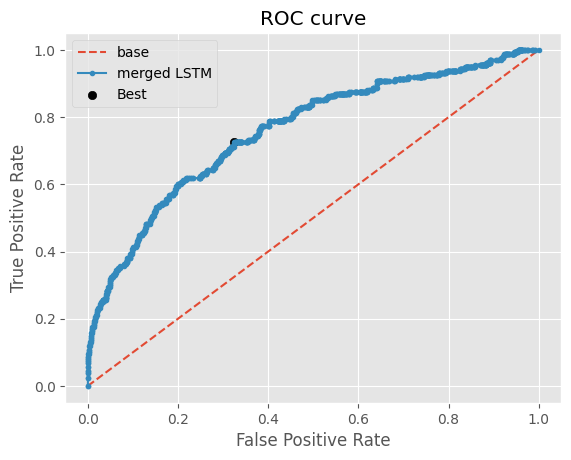

roc auc score 0.759
best threshold 0.016


,0,1,accuracy,macro avg,weighted avg
precision,0.99,0.03,0.68,0.51,0.98
recall,0.68,0.72,0.68,0.70,0.68
f1-score,0.80,0.06,0.68,0.43,0.79
support,10995.00,160.00,0.68,11155.00,11155.00


In [60]:
y_pred = model.predict([X_test_seq, X_test_fix]).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
idx = np.argmax(tpr - fpr)
best_thresh = thresholds[idx]

plt.plot([0, 1], [0, 1], linestyle='--', label='base')
plt.plot(fpr, tpr, marker='.', label='merged LSTM')
plt.title('ROC curve')
plt.scatter(fpr[idx], tpr[idx], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

print('roc auc score', roc_auc_score(y_test, y_pred).round(3))
print('best threshold', best_thresh.round(3))
pd.DataFrame(classification_report(y_test, y_pred>(best_thresh), output_dict=True)).round(2)

В виду того, что классы в данной работе значительно несбалансированы значение метрики precision и f1-score имеют низкое значение. В результате получили удовлетворительное значение основной метрики recall.

## Вывод и рекомендации по проделанной работе.

В данном проекте в качестве улучшения требуется рассмотреть возможность сбалансировать классы для более получения более точного результата. Также стоит рассмотреть возможность поиска новых признаков, как последовательных, так и признаков клиента.